<div style="display: flex; align-items: center; gap: 30px; padding-bottom: 10px;">
    <img src="fig/logo/logo_fwc.png" alt="Logo" style="width: 150px">
    <div>
        <h1 style="margin: 0; font-size: 2.0em;">TFM - Inteligencia Artificial para la Observación de la Tierra: Comparación de modelos para la Monitorización de la vegetación</h1>
        <h1></h1>
        <h2 style="margin: 5px 0 0 0; color: #555; font-size: 1.5em;">Adolfo Molada Tebar</h2>
    </div>
</div>

## MLP

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import display_functions
import helper_functions
import model_functions

2026-01-02 17:18:24.218512: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-02 17:18:24.270180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-02 17:18:25.422744: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Preparar el entorno de trabajo

In [3]:
current_dir = os.getcwd()

project_dir = os.path.join(current_dir, "fwc")
project_data = os.path.join(project_dir, "data")

project_data_training = os.path.join(project_data, "training")
project_models = os.path.join(project_dir,"models")

### Cargar los datos

In [4]:
feather_file_path = os.path.join(project_data_training, "data.feather")
data = pd.read_feather(feather_file_path)

In [5]:
data.describe()

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,15466.359788,0.433862,0.328589,0.349635,0.318131,0.354350,0.157438,0.357195,36.823065,-3.634057,...,0.098274,0.038967,18.770834,0.081939,0.043530,2.626863,0.342886,1.098454,1.086219,1.007287
std,7144.236501,0.608058,0.139269,0.127110,0.099329,0.159418,0.081765,0.130633,13.412162,2.665701,...,0.137972,0.025428,0.013241,0.052172,0.054708,2.116683,0.126894,0.132174,0.115080,0.191885
min,1.000000,0.000000,0.047059,0.086275,0.101961,0.061111,0.016129,0.101961,7.438742,-14.478152,...,-0.153846,-0.053763,18.717208,-0.102035,-0.098182,-2.450980,0.087484,0.821191,0.782604,0.437497
25%,6746.500000,0.000000,0.223529,0.258824,0.250980,0.212121,0.100893,0.260784,27.078731,-5.235742,...,0.021016,0.024955,18.763414,0.052272,0.011494,1.392157,0.250305,1.023251,1.012119,0.880594
50%,17646.000000,0.000000,0.309804,0.341176,0.317647,0.370370,0.137615,0.341176,35.882136,-3.757126,...,0.081967,0.038835,18.771643,0.080373,0.042105,2.333333,0.330585,1.087909,1.077919,0.977270
75%,17798.500000,1.000000,0.401961,0.419608,0.376471,0.484848,0.202290,0.423529,44.579033,-2.167105,...,0.155050,0.052012,18.778433,0.110365,0.073529,3.588235,0.413051,1.158725,1.141356,1.090591
max,29255.000000,2.000000,0.792157,0.835294,0.764706,0.888889,0.562500,0.835294,83.894231,6.945201,...,1.363605,0.152000,18.812741,0.358478,0.358489,11.352941,0.819611,2.117615,1.607835,1.737494


In [6]:
data.sample(5)

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
140,17781,1,0.341176,0.349020,0.317647,0.208333,0.089888,0.349020,37.417494,-2.454706,...,0.021053,0.028902,18.776698,0.058391,0.011364,2.156863,0.345087,1.022986,1.098762,1.074071
270,17693,1,0.678431,0.600000,0.439216,0.112022,0.352601,0.678431,64.029315,1.242512,...,-0.093458,0.035533,18.768686,0.094262,-0.061350,6.901961,0.605066,0.884392,1.366068,1.544639
557,17722,1,0.470588,0.494118,0.427451,0.225490,0.134921,0.494118,51.858608,-5.541449,...,0.043796,0.047817,18.758369,0.096560,0.024390,4.823529,0.484302,1.049998,1.155961,1.100915
53,6650,1,0.505882,0.501961,0.454902,0.153846,0.100775,0.505882,53.348379,-1.896450,...,-0.007092,0.021956,18.778141,0.045298,-0.003891,2.686275,0.499397,0.992246,1.103446,1.112067
221,17578,0,0.203922,0.223529,0.227451,0.527778,0.103448,0.227451,23.544606,-1.872394,...,0.098039,0.017857,18.783216,0.037190,0.045871,0.450980,0.219644,1.096148,0.982754,0.896548


### Datos

In [7]:
X = data.iloc[:, 2:] # variables / features
y = data.iloc[:, 1]  # etiquetas

print(X.shape)
print(y.shape)

(567, 26)
(567,)


### Hold-out externo

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify=y)

Número de clases

In [9]:
num_classes = len(np.unique(y))

#### Estandarización de los datos de entrenamiento

Antes de entrenar un MLP, es fundamental estandarizar los datos porque las redes neuronales son muy sensibles a la escala de las características. Si estas tienen rangos muy distintos, las entradas con valores grandes pueden dominar el cálculo de activaciones y los gradientes, haciendo que el entrenamiento sea más lento, inestable o incluso que la red no aprenda correctamente. Estandarizar (restar la media y dividir entre la desviación estándar) o normalizar los datos garantiza que todas las características estén en rangos comparables, acelerando la convergencia y mejorando la estabilidad numérica del modelo.

In [10]:
standardizer = StandardScaler()
X_train_std = standardizer.fit_transform(X_train)
X_test_std = standardizer.transform(X_test)

Convertir etiquetas a one-hot (estasmos en una clasificación multiclass)

In [11]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

Construcción del modelo MLP

In [12]:
# pruebas

#mlp_model = Sequential([
#    Dense(128, input_dim=X.shape[1], activation='relu'),
#    Dropout(0.3),
#    Dense(64, activation='relu'),
#    Dropout(0.3),
#    Dense(num_classes, activation='softmax')  # softmax para multiclass
#]) # f1-score 0.71

# mas profunda
#mlp_model = Sequential([
#    Dense(256, activation='relu', input_dim=X.shape[1]),
#    Dropout(0.3),
#    Dense(128, activation='relu'),
#    Dropout(0.3),
#    Dense(64, activation='relu'),
#    Dropout(0.3),
#    Dense(num_classes, activation='softmax')
#]) # 0.70, no mejora; la clase 2 no la discrimina

#mlp_model = Sequential([
#    Dense(256, activation='relu', input_dim=X.shape[1]),
#    BatchNormalization(),
#    Dropout(0.3),
#    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
#    BatchNormalization(),
#    Dropout(0.3),#3    Dense(num_classes, activation='softmax')
#])


In [13]:
mlp_model = Sequential([
    Dense(256, activation='relu', input_dim=X.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
]) # f1-score 0.83

I0000 00:00:1767370706.385792 4080877 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8981 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:65:00.0, compute capability: 8.6


Compilación del modelo

In [14]:
opt = Adam(learning_rate=0.001) # ahora 0.89 con 16 epocas
mlp_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,731 (163.01 KB)

 Trainable params: 40,963 (160.01 KB)

 Non-trainable params: 768 (3.00 KB)

Entrenamiento

In [15]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = mlp_model.fit(X_train_std, y_train_cat, 
                    validation_split=0.2, 
                    epochs=100,#50
                    batch_size=32,
                    verbose=2,
                    callbacks=[early_stop])

Epoch 1/100


2026-01-02 17:18:28.220337: I external/local_xla/xla/service/service.cc:163] XLA service 0x7674c001e670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-02 17:18:28.220352: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2026-01-02 17:18:28.251272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-02 17:18:28.441722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-01-02 17:18:28.562748: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-02 17:18:28.562816: I ext

12/12 - 9s - 714ms/step - accuracy: 0.6547 - loss: 1.1099 - val_accuracy: 0.7802 - val_loss: 0.7742
Epoch 2/100
12/12 - 0s - 8ms/step - accuracy: 0.7762 - loss: 0.8133 - val_accuracy: 0.8132 - val_loss: 0.6972
Epoch 3/100
12/12 - 0s - 9ms/step - accuracy: 0.7928 - loss: 0.7271 - val_accuracy: 0.8132 - val_loss: 0.6248
Epoch 4/100
12/12 - 0s - 8ms/step - accuracy: 0.7845 - loss: 0.6502 - val_accuracy: 0.7802 - val_loss: 0.5815
Epoch 5/100
12/12 - 0s - 8ms/step - accuracy: 0.7818 - loss: 0.6768 - val_accuracy: 0.7802 - val_loss: 0.5381
Epoch 6/100
12/12 - 0s - 8ms/step - accuracy: 0.8039 - loss: 0.6325 - val_accuracy: 0.7692 - val_loss: 0.5254
Epoch 7/100
12/12 - 0s - 9ms/step - accuracy: 0.7624 - loss: 0.5929 - val_accuracy: 0.6923 - val_loss: 0.5564
Epoch 8/100
12/12 - 0s - 8ms/step - accuracy: 0.8039 - loss: 0.5503 - val_accuracy: 0.7363 - val_loss: 0.5183
Epoch 9/100
12/12 - 0s - 8ms/step - accuracy: 0.8260 - loss: 0.5011 - val_accuracy: 0.7582 - val_loss: 0.4973
Epoch 10/100
12/12 -

Predicciones

In [16]:
y_pred_cat = mlp_model.predict(X_test_std)
y_pred = np.argmax(y_pred_cat, axis=1)

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step

2026-01-02 17:18:37.356035: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step


Métricas

In [17]:
mse, rmse, r2 = model_functions.compute_metrics(y_test,y_pred)

print("MSE:  ", mse)
print("RMSE: ", rmse)
print("R²:   ", r2)

report = model_functions.compute_classification_report(y_test, y_pred) # Reporte detallado por clase
print(report)
conf_matrix = model_functions.compute_confusion_matrix(y_test, y_pred) # Matriz de confusión
print(conf_matrix)

MSE:   0.2719298245614035
RMSE:  0.5214689104456789
R²:    0.25818639798488663
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        73
           1       0.65      0.44      0.53        34
           2       0.24      0.57      0.33         7

    accuracy                           0.75       114
   macro avg       0.60      0.64      0.59       114
weighted avg       0.79      0.75      0.76       114

[[67  5  1]
 [ 7 15 12]
 [ 0  3  4]]


Matriz de confusión

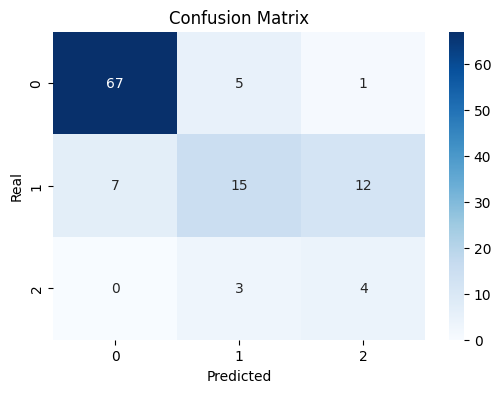

In [18]:
display_functions.plot_confusion_matrix(conf_matrix)

Curvas de aprendizaje

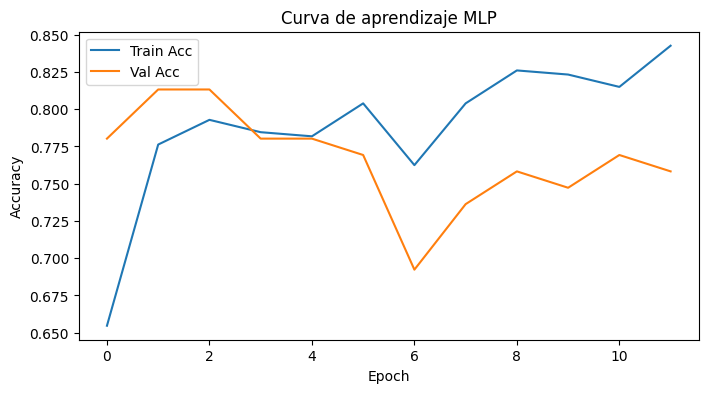

In [19]:
display_functions.plot_learning_curves(history, model_name="MLP")

## Save MLP model

In [20]:
mlp_model_path = os.path.join(project_models, "mlp_model.pkl")

model_functions.save_model(mlp_model, mlp_model_path)

Necesito guardar el estandarizador para predecir y generar las mascaras

In [21]:
mlp_model_standarized_path = os.path.join(project_models, "mlp_model_standarized.pkl")

model_functions.save_model_data_standardizer(standardizer, mlp_model_standarized_path)